In [1]:
import re
import math

In [2]:
#UNK is used for unseen words in training vocabulary
UNK= None
#sentence start and end
sent_start= "<s>"
send_end= "</s>"


In [3]:
def read_sentences_from_file(path):
    with open(path, "r") as f:
        #string.rstrip("\n") removes string portion after \n or new line
        #re.split( arg1, arg2): from arg2 extract arg1 pattern
        string= [re.split("\s+", line.rstrip("\n")) for line in f]

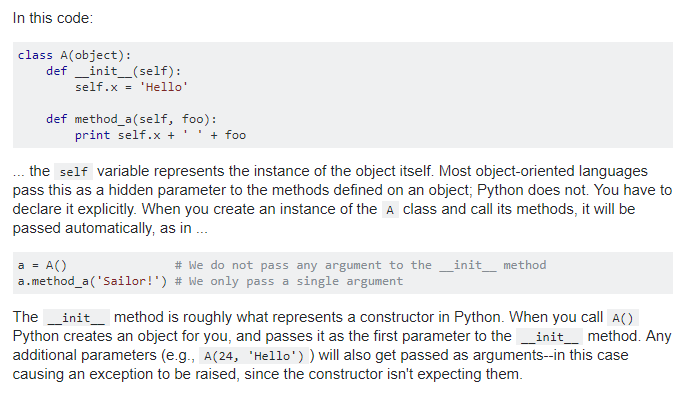

In [4]:
class unigram_language_model:
    def __init__(self, sentences, smoothing=False):
        self.unigram_frequencies= dict()
        self.corpus_length= 0
        for sentence in sentences:
            for word in sentence:
                #dict.get(key,val) , if the key is not present in the dict this func will assign "val" value to key and if it is already present then it returns the value of the key
                self.unigram_frequencies[word]= self.unigram_frequencies.get(word, 0) + 1
                if(word != sent_start and word != sent_end):
                    self.corpus_length+=1
        # subtract 2 from the total no. of unique words becoz sent_start and sent_end are also there
        self.unique_words= len(self.unigram_frequencies) -2
        self.smoothing= smoothing
        
    def calculate_unigram_probability(self, word):
        word_probability_numerator= self.unigram_frequencies.get(word, 0)
        word_probability_denominator= self.corpus_length
        if(self.smoothing):
            #add 1 smoothing is used 
            #1 is added to each word count in numerator and for denominator total unique words length is used
            word_probability_numerator += 1
            word_probability_denominator += self.unique_words +1 # here 1 is for UNK- unseen word
        return float(word_probability_numerator)/float(word_probability_denominator)
    
    def calculate_sentence_probability(self, sentence, normalize_probability=True):
        sentence_probability_log_sum=0
        for word in sentence:
            if(word != sent_start and word !=sent_end):
                word_probability= self.calculate_unigram_probability(word)
                sentence_probability_log_sum += math.log(word_probability, 2)
        return math.pow(2, sentence_probability_log_sum) if(normalize_probability) else sentence_probability_log_sum
    
    def sorted_vocabulary(self):
        full_vocab= list(self.unigram_frequencies.keys())
        full_vocab.remove(sent_start)
        full_vocab.remove(sent_end)
        full_vocab.sort()
        full_vocab.append(UNK)
        full_vocab.append(sent_start)
        full_vocab.append(sent_end)
        return full_vocab

In [5]:
class bigram_language_model(unigram_language_model):
    def __init__(self, sentences, smoothing=False):
        self.bigram_frequencies= dict()
        self.unique_bigrams= set()
        for sentence in sentences:
            previous_word= None
            for word in sentence:
                if(previous_word != None):
                    self.bigram_frequencies[(previous_word, word)] = self.bigram_frequencies.get((previous_word, word), 0) + 1
                    if(previous_word != sent_start and word != sent_end):
                        self.unique_bigrams.add((previous_word, word))
                previous_word= word
        self.unique_bigram_words= len(self.unigram_frequencies)
        
    def calculate_bigram_probability(self, previous_word, word):
        bigram_word_probability_numerator= self.bigram_frequencies.get((previous_word, word), 0)
        bigram_word_probability_denominator= self.unigram_frequencies.get(previous_word, 0)
        if(self.smoothing):
            bigram_word_probability_numerator+=1
            bigram_word_probability_denominator+= self.unique_bigram_words
        return 0.0 if(bigram_word_probability_numerator==0 or bigram_word_probability_denominator==0) else float(bigram_word_probability_numerator)/float(bigram_word_probability_denominator)
    
    def calculate_bigram_sentence_probability(self, sentence, normalize_probability=True):
        bigram_sentence_probability_log_sum= 0
        previous_word= None
        for word in sentence:
            if(previous_word != None):
                bigram_sentence_probability = self.calculate_bigram_probability(previous_word, word)
                bigram_sentence_probability_log_sum += math.log(bigram_sentence_probability, 2)
            previous_word= word
        return pow(2, bigram_sentence_probability_log_sum) if(normalize_probability) else bigram_sentence_probability_log_sum

In [6]:
# Now, we calculate number of unigrams and bigrams
def calculate_number_of_unigrams(sentences):
    unigram_count=0
    for sentence in sentences:
        # remove 2 for <s> and </s>
        unigram_count += len(sentence) -2
    return unigram_count

def calculate_number_of_bigrams(sentences):
    bigram_count=0
    for sentence in sentences:
        #remove 1 for number of bigrams in sentence
        bigram_count += len(sentence) -1
    return bigram_count

In [7]:
# Calculate perplexity values
def calculate_unigram_perplexity(model, sentences):
    unigram_count= calculate_number_of_unigrams(sentences)
    sentence_probability_log_sum= 0
    for sentence in sentences:
        try:
            sentence_probability_log_sum -= math.log(model.calculate_sentence_probability(sentence), 2)
        except:
            sentence_probability_log_sum -= float('-inf')
    return math.pow(2, sentence_probability_log_sum/unigram_count)

def calculate_bigram_perplexity(model, sentences):
    bigram_count= calculate_number_of_bigrams(sentences)
    sentence_probability_log_sum= 0
    for sentence in sentences:
        try:
            sentence_probability_log_sum -= math.log(model.calculate_bigram_sentence_probability(sentence), 2)
        except:
            sentence_probability_log_sum -= float('-inf')
    return math.pow(2, sentence_probability_log_sum)

In [8]:
# print unigram and bigram probs
def print_unigram_probs(sorted_vocab_keys, model):
    for vocab_key in sorted_vocab_keys:
        if vocab_key != SENTENCE_START and vocab_key != SENTENCE_END:
            print("{}: {}".format(vocab_key if vocab_key != UNK else "UNK",
                                       model.calculate_unigram_probability(vocab_key)), end=" ")
    print("")

def print_bigram_probs(sorted_vocab_keys, model):
    print("\t\t", end="")
    for vocab_key in sorted_vocab_keys:
        if vocab_key != SENTENCE_START:
            print(vocab_key if vocab_key != UNK else "UNK", end="\t\t")
    print("")
    for vocab_key in sorted_vocab_keys:
        if vocab_key != SENTENCE_END:
            print(vocab_key if vocab_key != UNK else "UNK", end="\t\t")
            for vocab_key_second in sorted_vocab_keys:
                if vocab_key_second != SENTENCE_START:
                    print("{0:.5f}".format(model.calculate_bigram_probabilty(vocab_key, vocab_key_second)), end="\t\t")
            print("")
    print("")

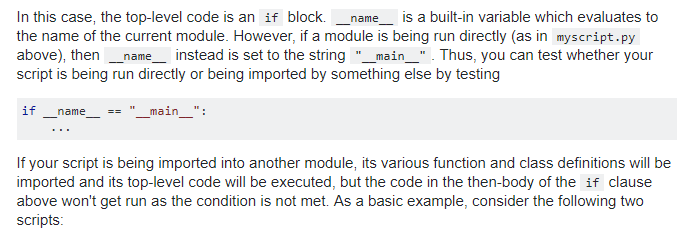

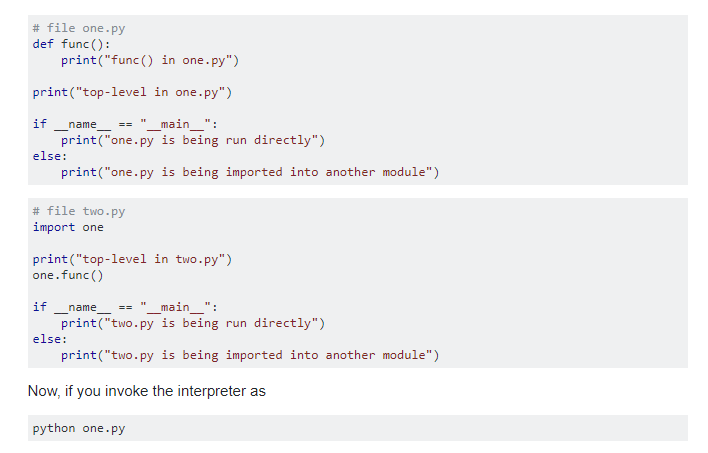

In [9]:
if(__name__ == "__main__"):
    twitter_dataset= read_sentences_from_file("sample.txt")
    twitter_dataset_test= read_sentences_from_file("test_data.txt")
    twitter_dataset_model_unsmoothed= bigram_language_model(twitter_dataset)
    twitter_dataset_model_smoothed= bigram_language_model(twitter_dataset, smoothing= True)
    sorted_vocab_keys= twitter_dataset_model_unsmoothed.sorted_vocabulary()
    
    print("---------------- Toy dataset ---------------\n")
    print("=== UNIGRAM MODEL ===")
    print("- Unsmoothed  -")
    print_unigram_probs(sorted_vocab_keys, twitter_dataset_model_unsmoothed)
    print("\n- Smoothed  -")
    print_unigram_probs(sorted_vocab_keys, twitter_dataset_model_smoothed)

    print("")

    print("=== BIGRAM MODEL ===")
    print("- Unsmoothed  -")
    print_bigram_probs(sorted_vocab_keys, twitter_dataset_model_unsmoothed)
    print("- Smoothed  -")
    print_bigram_probs(sorted_vocab_keys, twitter_dataset_model_smoothed)

    print("")

    print("== SENTENCE PROBABILITIES == ")
    longest_sentence_len = max([len(" ".join(sentence)) for sentence in twitter_dataset_test]) + 5
    print("sent", " " * (longest_sentence_len - len("sent") - 2), "uprob\t\tbiprob")
    for sentence in twitter_dataset_test:
        sentence_string = " ".join(sentence)
        print(sentence_string, end=" " * (longest_sentence_len - len(sentence_string)))
        print("{0:.5f}".format(twitter_dataset_model_smoothed.calculate_sentence_probability(sentence)), end="\t\t")
        print("{0:.5f}".format(twitter_dataset_model_smoothed.calculate_bigram_sentence_probability(sentence)))        
        
    print("")

    print("== TEST PERPLEXITY == ")
    print("unigram: ", calculate_unigram_perplexity(twitter_dataset_model_smoothed, twitter_dataset_test))
    print("bigram: ", calculate_bigram_perplexity(twitter_dataset_model_smoothed, twitter_dataset_test))
    
    print("")

    actual_dataset = read_sentences_from_file("sample.txt")
    actual_dataset_test = read_sentences_from_file("test_data.txt")
    actual_dataset_model_smoothed = bigram_language_model(actual_dataset, smoothing=True)
    print("---------------- Actual dataset ----------------\n")
    print("PERPLEXITY of sample.txt")
    print("unigram: ", calculate_unigram_perplexity(actual_dataset_model_smoothed, actual_dataset))
    print("bigram: ", calculate_bigram_perplexity(actual_dataset_model_smoothed, actual_dataset))

    print("")

    print("PERPLEXITY of test_data.txt")
    print("unigram: ", calculate_unigram_perplexity(actual_dataset_model_smoothed, actual_dataset_test))
    print("bigram: ", calculate_bigram_perplexity(actual_dataset_model_smoothed, actual_dataset_test))

TypeError: 'NoneType' object is not iterable